# Workshop example with working Duran-Grossmann formulation


Learning outcomes
------------------------------

- Construct a steady-state flowsheet using the IDAES unit model library
- Connecting unit models in a  flowsheet using Arcs
- Using the SequentialDecomposition tool to initialize a flowsheet with recycle
- Fomulate and solve an optimization problem
    - Defining an objective function
    - Setting variable bounds
    - Adding additional constraints 


Problem Statement
------

Hydrodealkylation is a chemical reaction that often involves reacting
an aromatic hydrocarbon in the presence of hydrogen gas to form a
simpler aromatic hydrocarbon devoid of functional groups,. In this
example, toluene will be reacted with hydrogen gas at high temperatures
 to form benzene via the following reaction:

**C<sub>6</sub>H<sub>5</sub>CH<sub>3</sub> + H<sub>2</sub> → C<sub>6</sub>H<sub>6</sub> + CH<sub>4</sub>**


This reaction is often accompanied by an equilibrium side reaction
which forms diphenyl, which we will neglect for this example.

This example is based on the 1967 AIChE Student Contest problem as
present by Douglas, J.M., Chemical  Design of Chemical Processes, 1988,
McGraw-Hill.

The flowsheet that we will be using for this module is shown below with the stream conditions. We will be processing toluene and hydrogen to produce at least 370 TPY of benzene. As shown in the flowsheet, there are two flash tanks, F101 to separate out the non-condensibles and F102 to further separate the benzene-toluene mixture to improve the benzene purity.  Note that typically a distillation column is required to obtain high purity benzene but that is beyond the scope of this workshop. The non-condensibles separated out in F101 will be partially recycled back to M101 and the rest will be either purged or combusted for power generation.We will assume ideal gas for this flowsheet. The properties required for this module is available in the same directory:

- hda_ideal_VLE.py
- hda_reaction.py

The state variables chosen for the property package are **flows of component by phase, temperature and pressure**. The components considered are: **toluene, hydrogen, benzene and methane**. Therefore, every stream has 8 flow variables, 1 temperature and 1 pressure variable. 

![](module_2_flowsheet.png)




Importing required pyomo and idaes components
-----------
To construct a flowsheet, we will need several components from the pyomo and idaes package. Let us first import the following components from Pyomo:
- Constraint (to write constraints)
- Var (to declare variables)
- ConcreteModel (to create the concrete model object)
- Expression (to evaluate values as a function of variables defined in the model)
- Objective (to define an objective function for optimization)
- SolverFactory (to solve the problem)
- TransformationFactory (to apply certain transformations)
- Arc (to connect two unit models)
- SequentialDecomposition (to initialize the flowsheet in a sequential mode)

For further details on these components, please refer to the pyomo documentation: https://pyomo.readthedocs.io/en/latest/


In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.network import Arc, SequentialDecomposition
from idaes.core.util.model_statistics import unfixed_variables_set
from idaes.core.util.model_statistics import large_residuals_set

from idaes.functions.DuranGrossmann import heat_integration, print_HX_results, generate_curves, Heat_ex_data


From idaes, we will be needing the FlowsheetBlock and the following unit models:
- Mixer
- Heater
- StoichiometricReactor
- <span style="color:blue">**Flash**</span>
- Separator (splitter) 
- PressureChanger

In [2]:
from idaes.core import FlowsheetBlock

In [3]:
from idaes.unit_models import (PressureChanger,
                               Mixer,
                               Separator as Splitter,
                               Heater,
                               StoichiometricReactor)

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Now, import the remaining unit models highlighted in blue above and run the cell using `Shift+Enter` after typing in the code. 
</div>


In [4]:
from idaes.unit_models import Flash

We will also be needing some utility tools to put together the flowsheet and calculate the degrees of freedom. 

In [5]:
from idaes.unit_models.pressure_changer import ThermodynamicAssumption
from idaes.core.util.model_statistics import degrees_of_freedom

Importing required thermo and reaction package
-----------


The final set of imports are to import the thermo and reaction package for the HDA process. We have created a custom thermo package that assumes Ideal Gas with support for VLE. 

The reaction package here is very simple as we will be using only a StochiometricReactor and the reaction package consists the stochiometric coefficients for the reaction and the parameter for the heat of reaction. 

Let us import the following modules and they are in the same directory as this jupyter notebook:
      <ul>
         <li>hda_ideal_VLE as thermo_props</li>
         <li>hda_reaction as reaction_props </li>
      </ul>
</div>

In [6]:
import hda_ideal_VLE as thermo_props
import hda_reaction as reaction_props

Constructing the Flowsheet
----------------------------------

We have now imported all the components, unit models, and property modules we need to construct a flowsheet. Let us create a ConcreteModel and add the flowsheet block as we did in module 1. 

In [7]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})

We now need to add the property packages to the flowsheet. Unlike Module 1, where we only had a thermo property package, for this flowsheet we will also need to add a reaction property package. 

In [8]:
m.fs.thermo_params = thermo_props.HDAParameterBlock()
m.fs.reaction_params = reaction_props.HDAReactionParameterBlock(
        default={"property_package": m.fs.thermo_params})

Adding Unit Models
-----

Let us start adding the unit models we have imported to the flowsheet. Here, we are adding the Mixer (assigned a name M101) and a Heater (assigned a name H101). Note that, all unit models need to be given a property package argument. In addition to that, there are several arguments depending on the unit model, please refer to the documentation for more details (https://idaes-pse.readthedocs.io/en/latest/models/index.html). For example, the Mixer unit model here is given a `list` consisting of names to the three inlets. 

In [9]:
m.fs.M101 = Mixer(default={"property_package": m.fs.thermo_params,
                           "inlet_list": ["toluene_feed", "hydrogen_feed", "vapor_recycle"]})

m.fs.H101 = Heater(default={"property_package": m.fs.thermo_params,
                            "has_pressure_change": False,
                            "has_phase_equilibrium": True})

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Let us now add the StoichiometricReactor(assign the name R101) and pass the following arguments:
      <ul>
         <li>"property_package": m.fs.thermo_params</li>
         <li>"reaction_package": m.fs.reaction_params </li>
         <li>"has_heat_of_reaction": True </li>
         <li>"has_heat_transfer": True</li>
         <li>"has_pressure_change": False</li>
      </ul>
</div>

In [10]:
m.fs.R101 = StoichiometricReactor(
            default={"property_package": m.fs.thermo_params,
                     "reaction_package": m.fs.reaction_params,
                     "has_heat_of_reaction": True,
                     "has_heat_transfer": True,
                     "has_pressure_change": False})

Let us now add the Flash(assign the name F101) and pass the following arguments:
      <ul>
         <li>"property_package": m.fs.thermo_params</li>
         <li>"has_heat_transfer": True</li>
         <li>"has_pressure_change": False</li>
      </ul>

In [11]:
m.fs.F101 = Flash(default={"property_package": m.fs.thermo_params,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

Let us now add the Splitter(S101), PressureChanger(C101) and the second Flash(F102). 

In [12]:
m.fs.S101 = Splitter(default={"property_package": m.fs.thermo_params,
                               "ideal_separation": False,
                               "outlet_list": ["purge", "recycle"]})
    

m.fs.C101 = PressureChanger(default={
            "property_package": m.fs.thermo_params,
            "compressor": True,
            "thermodynamic_assumption": ThermodynamicAssumption.isothermal})
    
m.fs.F102 = Flash(default={"property_package": m.fs.thermo_params,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

Connecting Unit Models using Arcs
-----
We have now added all the unit models we need to the flowsheet. However, we have not yet specifed how the units are to be connected. To do this, we will be using the `Arc` which is a pyomo component that takes in two arguments: `source` and `destination`. Let us connect the outlet of the mixer(M101) to the inlet of the heater(H101). 

In [13]:
m.fs.s03 = Arc(source=m.fs.M101.outlet, destination=m.fs.H101.inlet)


![](module_2_flowsheet.png) 

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Now, connect the H101 outlet to the R101 inlet using the cell above as a guide. 
</div>



In [14]:
m.fs.s04 = Arc(source=m.fs.H101.outlet, destination=m.fs.R101.inlet)

We will now be connecting the rest of the flowsheet as shown below. Notice how the outlet names are different for the flash tanks F101 and F102 as they have a vapor and a liquid outlet. 

In [15]:
m.fs.s05 = Arc(source=m.fs.R101.outlet, destination=m.fs.F101.inlet)
m.fs.s06 = Arc(source=m.fs.F101.vap_outlet, destination=m.fs.S101.inlet)
m.fs.s08 = Arc(source=m.fs.S101.recycle, destination=m.fs.C101.inlet)
m.fs.s09 = Arc(source=m.fs.C101.outlet,
               destination=m.fs.M101.vapor_recycle)
m.fs.s10 = Arc(source=m.fs.F101.liq_outlet, destination=m.fs.F102.inlet)

We have now connected the unit model block using the arcs. However, each of these arcs link to ports on the two unit models that are connected. In this case, the ports consist of the state variables that need to be linked between the unit models. Pyomo provides a convenient method to write these equality constraints for us between two ports and this is done as follows:

In [16]:
TransformationFactory("network.expand_arcs").apply_to(m)

Adding expressions to compute purity and operating costs
---
In this section, we will add a few Expressions that allows us to evaluate the performance. Expressions provide a convenient way of calculating certain values that are a function of the variables defined in the model. For more details on Expressions, please refer to: https://pyomo.readthedocs.io/en/latest/pyomo_modeling_components/Expressions.html

For this flowsheet, we are interested in computing the purity of the product Benzene stream (i.e. the mole fraction) and the operating cost which is a sum of the cooling and heating cost. 

Let us first add an Expression to compute the mole fraction of benzene in the `vap_outlet` of F102 which is our product stream. Please note that the var flow_mol_phase_comp has the index - [time, phase, component]. As this is a steady-state flowsheet, the time index by default is 0. The valid phases are ["Liq", "Vap"]. Similarly the valid component list is ["benzene", "toluene", "hydrogen", "methane"].

In [17]:
m.fs.purity = Expression(
        expr=m.fs.F102.vap_outlet.flow_mol_phase_comp[0, "Vap", "benzene"] /
        (m.fs.F102.vap_outlet.flow_mol_phase_comp[0, "Vap", "benzene"]
         + m.fs.F102.vap_outlet.flow_mol_phase_comp[0, "Vap", "toluene"]))

Now, let us add an expression to compute the cooling cost assuming a cost of 0.212E-4 $/kW. Note that cooling utility is required for the reactor (R101) and the first flash (F101). 

In [18]:
m.fs.cooling_cost = Expression(expr=0.212e-7 * (-m.fs.F101.heat_duty[0]) +
                                   0.212e-7 * (-m.fs.R101.heat_duty[0]))


Now, let us add an expression to compute the heating cost assuming the utility cost as follows:
      <ul>
         <li>2.2E-4 dollars/kW for H101</li>
         <li>1.9E-4 dollars/kW for F102</li>
      </ul>
Note that the heat duty is in units of watt (J/s). 

In [19]:
m.fs.heating_cost = Expression(expr=2.2e-7 * m.fs.H101.heat_duty[0] +
                                   1.9e-7 * m.fs.F102.heat_duty[0])

Let us now add an expression to compute the total operating cost per year which is basically the sum of the cooling and heating cost we defined above. 

In [20]:
m.fs.operating_cost = Expression(expr=(3600 * 24 * 365 *
                                           (m.fs.heating_cost +
                                            m.fs.cooling_cost)))

Fixing feed conditions
---

Let us first check how many degrees of freedom exist for this flowsheet using the `degrees_of_freedom` tool we imported earlier. 

In [21]:
print(degrees_of_freedom(m))

29


We will now be fixing the toluene feed stream to the conditions shown in the flowsheet above. Please note that though this is a pure toluene feed, the remaining components are still assigned a very small non-zero value to help with convergence and initializing. 

In [22]:
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Vap", "benzene"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Vap", "toluene"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Vap", "hydrogen"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Vap", "methane"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Liq", "benzene"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Liq", "toluene"].fix(0.30)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Liq", "hydrogen"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Liq", "methane"].fix(1e-5)
m.fs.M101.toluene_feed.temperature.fix(303.2)
m.fs.M101.toluene_feed.pressure.fix(350000)


Similarly, let us fix the hydrogen feed to the following conditions in the next cell:
      <ul>
         <li>F<sub>H2</sub> = 0.30 mol/s</li>
         <li>F<sub>CH4</sub> = 0.02 mol/s</li>
         <li>Remaining components = 1e-5 mol/s</li>
         <li>T = 303.2 K</li>
         <li>P = 350000 Pa</li>
      </ul>



In [23]:
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Vap", "benzene"].fix(1e-5)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Vap", "toluene"].fix(1e-5)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Vap", "hydrogen"].fix(0.30)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Vap", "methane"].fix(0.02)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Liq", "benzene"].fix(1e-5)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Liq", "toluene"].fix(1e-5)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Liq", "hydrogen"].fix(1e-5)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Liq", "methane"].fix(1e-5)
m.fs.M101.hydrogen_feed.temperature.fix(303.2)
m.fs.M101.hydrogen_feed.pressure.fix(350000)

Fixing unit model specifications
---

Now that we have fixed our inlet feed conditions, we will now be fixing the operating conditions for the unit models in the flowsheet. Let us set set the H101 outlet temperature to 600 K. 

In [24]:
m.fs.H101.outlet.temperature.fix(600)

For the StoichiometricReactor, we have to define the conversion in terms of toluene. This requires us to create a new variable for specifying the conversion and adding a Constraint that defines the conversion with respect to toluene. The second degree of freedom for the reactor is to define the heat duty. In this case, let us assume the reactor to be adiabatic i.e. Q = 0. 

In [25]:
m.fs.R101.conversion = Var(initialize=0.75, bounds=(0, 1))

m.fs.R101.conv_constraint = Constraint(
    expr=m.fs.R101.conversion*m.fs.R101.inlet.
    flow_mol_phase_comp[0, "Vap", "toluene"] ==
    (m.fs.R101.inlet.flow_mol_phase_comp[0, "Vap", "toluene"] -
     m.fs.R101.outlet.flow_mol_phase_comp[0, "Vap", "toluene"]))

m.fs.R101.conversion.fix(0.75)
m.fs.R101.heat_duty.fix(0)

The Flash conditions for F101 can be set as follows. 

In [26]:
m.fs.F101.vap_outlet.temperature.fix(325.0)
m.fs.F101.deltaP.fix(0)

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Set the conditions for Flash F102 to the following conditions:
      <ul>
         <li>T = 375 K</li>
         <li>deltaP = -200000</li>
      </ul>

Use Shift+Enter to run the cell once you have typed in your code. 
</div>

In [27]:
m.fs.F102.vap_outlet.temperature.fix(375)
m.fs.F102.deltaP.fix(-200000)

Let us fix the purge split fraction to 20% and the outlet pressure of the compressor is set to 350000 Pa. 

In [28]:
m.fs.S101.split_fraction[0, "purge"].fix(0.2)
m.fs.C101.outlet.pressure.fix(350000)

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
We have now defined all the feed conditions and the inputs required for the unit models. The system should now have 0 degrees of freedom i.e. should be a square problem. Please check that the degrees of freedom is 0. 

Use Shift+Enter to run the cell once you have typed in your code. 
</div>

In [29]:
print(degrees_of_freedom(m))

0


Initialization
------------------

This section will demonstrate how to use the built-in sequential decomposition tool to initialize our flowsheet.

![](module_2_flowsheet.png) 


Let us first create an object for the SequentialDecomposition and specify our options for this. 

In [30]:
seq = SequentialDecomposition()
seq.options.select_tear_method = "heuristic"
seq.options.tear_method = "Wegstein"
seq.options.iterLim = 5

# Using the SD tool
G = seq.create_graph(m)
heuristic_tear_set = seq.tear_set_arcs(G, method="heuristic")
order = seq.calculation_order(G)

Which is the tear stream? Display tear set and order

In [31]:
for o in heuristic_tear_set:
    print(o.name)

fs.s03


What sequence did the SD tool determine to solve this flowsheet with the least number of tears? 

In [32]:
for o in order:
    print(o[0].name)

fs.H101
fs.R101
fs.F101
fs.S101
fs.C101
fs.M101


 

![](module_2_tear_stream.png) 


The SequentialDecomposition tool has determined that the tear stream is the mixer outlet. We will need to provide a reasonable guess for this.

In [33]:
tear_guesses = {
        "flow_mol_phase_comp": {
                (0, "Vap", "benzene"): 1e-5,
                (0, "Vap", "toluene"): 1e-5,
                (0, "Vap", "hydrogen"): 0.30,
                (0, "Vap", "methane"): 0.02,
                (0, "Liq", "benzene"): 1e-5,
                (0, "Liq", "toluene"): 0.30,
                (0, "Liq", "hydrogen"): 1e-5,
                (0, "Liq", "methane"): 1e-5},
        "temperature": {0: 303},
        "pressure": {0: 350000}}

# Pass the tear_guess to the SD tool
seq.set_guesses_for(m.fs.H101.inlet, tear_guesses)

Next, we need to tell the tool how to initialize a particular unit. We will be writing a python function which takes in a "unit" and calls the initialize method on that unit. 

In [34]:
def function(unit):
        unit.initialize(outlvl=1)

We are now ready to initialize our flowsheet in a sequential mode. Note that we specifically set the iteration limit to be 5 as we are trying to use this tool only to get a good set of initial values such that IPOPT can then take over and solve this flowsheet for us. 

In [35]:
seq.run(m, function)

2020-02-21 11:19:37 - INFO - idaes.core.unit_model - fs.H101 Initialisation Step 1 Complete.
2020-02-21 11:19:37 - INFO - idaes.core.unit_model - fs.H101 Initialisation Step 2 Complete.
2020-02-21 11:19:37 - INFO - idaes.core.unit_model - fs.H101 Initialisation Complete.
2020-02-21 11:19:37 - INFO - idaes.core.unit_model - fs.R101 Initialisation Step 1 Complete.
2020-02-21 11:19:37 - INFO - idaes.core.unit_model - fs.R101 Initialisation Step 2 Complete.
2020-02-21 11:19:37 - INFO - idaes.core.unit_model - fs.R101 Initialisation Complete.
2020-02-21 11:19:37 - INFO - idaes.core.unit_model - fs.F101 Initialisation Step 1 Complete.
2020-02-21 11:19:37 - INFO - idaes.core.unit_model - fs.F101 Initialisation Step 2 Complete.
2020-02-21 11:19:37 - INFO - idaes.core.unit_model - fs.F101 Initialisation Complete.
2020-02-21 11:19:38 - INFO - idaes.unit_models.separator - fs.S101 Initialisation Complete.
2020-02-21 11:19:38 - INFO - idaes.core.unit_model - fs.F102 Initialisation Step 1 Complete.

2020-02-21 11:19:43 - INFO - idaes.core.unit_model - fs.R101 Initialisation Step 2 Complete.
2020-02-21 11:19:43 - INFO - idaes.core.unit_model - fs.R101 Initialisation Complete.
2020-02-21 11:19:43 - INFO - idaes.core.unit_model - fs.F101 Initialisation Step 1 Complete.
2020-02-21 11:19:43 - INFO - idaes.core.unit_model - fs.F101 Initialisation Step 2 Complete.
2020-02-21 11:19:43 - INFO - idaes.core.unit_model - fs.F101 Initialisation Complete.
2020-02-21 11:19:43 - INFO - idaes.unit_models.separator - fs.S101 Initialisation Complete.
2020-02-21 11:19:43 - INFO - idaes.core.unit_model - fs.C101 Initialisation Step 1 Complete.
2020-02-21 11:19:43 - INFO - idaes.core.unit_model - fs.C101 Initialisation Step 2 Complete.
2020-02-21 11:19:43 - INFO - idaes.core.unit_model - fs.C101 Initialisation Complete.
2020-02-21 11:19:43 - INFO - idaes.unit_models.mixer - fs.M101 Initialisation Complete.


2020-02-21 11:19:43 - INFO - idaes.core.unit_model - fs.F102 Initialisation Step 1 Complete.
2020-02-21 11:19:43 - INFO - idaes.core.unit_model - fs.F102 Initialisation Step 2 Complete.
2020-02-21 11:19:43 - INFO - idaes.core.unit_model - fs.F102 Initialisation Complete.


<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
We have now initialized the flowsheet. Let us run the flowsheet in a simulation mode to look at the results. To do this, complete the last line of code where we pass the model to the solver. You will need to type the following:
    
results = solver.solve(m, tee=True)

Use Shift+Enter to run the cell once you have typed in your code. 
</div>



In [36]:
m.display()

Model unknown

  Variables:
    None

  Objectives:
    None

  Constraints:
    None

  Blocks:
    Block fs
    
      Variables:
        None
    
      Objectives:
        None
    
      Constraints:
        None
    
      Blocks:
        Block fs.thermo_params
        
          Variables:
            None
        
          Objectives:
            None
        
          Constraints:
            None
        Block fs.reaction_params
        
          Variables:
            None
        
          Objectives:
            None
        
          Constraints:
            None
        Block fs.M101
        
          Variables:
            minimum_pressure : Variable for calculating minimum inlet pressure
                Size=3, Index=fs.M101.minimum_pressure_index
                Key      : Lower : Value              : Upper : Fixed : Stale : Domain
                (0.0, 1) :  None :           350000.0 :  None : False : False :  Reals
                (0.0, 2) :  None : 349999.999

                     ('Liq', 'benzene') :   0.0 : -1.5133991837501526e-09 :   0.0
                    ('Liq', 'hydrogen') :   0.0 :                     0.0 :   0.0
                     ('Liq', 'methane') :   0.0 :                     0.0 :   0.0
                     ('Liq', 'toluene') :   0.0 : -1.7462298274040222e-09 :   0.0
                     ('Vap', 'benzene') :   0.0 :                     0.0 :   0.0
                    ('Vap', 'hydrogen') :   0.0 :   3.694822225952521e-13 :   0.0
                     ('Vap', 'methane') :   0.0 :  -3.979039320256561e-13 :   0.0
                     ('Vap', 'toluene') :   0.0 :                     0.0 :   0.0
            Block fs.M101.vapor_recycle_state[0.0]
            
              Variables:
                flow_mol_phase_comp : Phase-component molar flow rates [mol/s]
                    Size=8, Index=fs.M101.vapor_recycle_state[0.0].flow_mol_phase_comp_index
                    Key                 : Lower : Value                 : Upper : F

                _Vap_pressure_ref : Size=1, Index=fs.time
                    Key : Lower  : Value              : Upper  : Fixed : Stale : Domain
                    0.0 : 101325 : 149999.99999999267 : 400000 : False : False : NonNegativeReals
                _Liq_temperature_ref : Size=1, Index=fs.time
                    Key : Lower  : Value : Upper : Fixed : Stale : Domain
                    0.0 : 298.15 :   375 :  1000 :  True :  True : NonNegativeReals
                _Liq_pressure_ref : Size=1, Index=fs.time
                    Key : Lower  : Value              : Upper  : Fixed : Stale : Domain
                    0.0 : 101325 : 149999.99999999267 : 400000 : False : False : NonNegativeReals
            
              Objectives:
                None
            
              Constraints:
                None
        Block fs.s03_expanded
        
          Variables:
            None
        
          Objectives:
            None
        
          Constraints:
            flo

In [37]:
# Create the solver object
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6, 'max_iter': 5000}

# Solve the model
results = solver.solve(m, tee=True)

Ipopt 3.11.1: tol=1e-06
max_iter=5000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1022
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      898

Total number of variables............................:      338
                     variables with only lower bounds:        0
                variables with lower and

Analyze the results of the square problem
-------------------------

What is the total operating cost? 

In [38]:
print('operating cost = $', value(m.fs.operating_cost))

operating cost = $ 419122.3387677939


For this operating cost, what is the amount of benzene we are able to produce and what purity we are able to achieve? 

In [39]:
from workshoptools import print_ports_summary

print_ports_summary([m.fs.F102.vap_outlet])

print()
print('benzene purity = ', value(m.fs.purity))

                                     Variable	fs.F102.vap_outlet	
---------------------------------------------	------------------	
 flow_mol_phase_comp[(0.0, 'Liq', 'benzene')]	          0.000000	
 flow_mol_phase_comp[(0.0, 'Liq', 'toluene')]	          0.000000	
flow_mol_phase_comp[(0.0, 'Liq', 'hydrogen')]	          0.000000	
 flow_mol_phase_comp[(0.0, 'Liq', 'methane')]	          0.000000	
 flow_mol_phase_comp[(0.0, 'Vap', 'benzene')]	          0.141979	
 flow_mol_phase_comp[(0.0, 'Vap', 'toluene')]	          0.030264	
flow_mol_phase_comp[(0.0, 'Vap', 'hydrogen')]	          0.000000	
 flow_mol_phase_comp[(0.0, 'Vap', 'methane')]	          0.000000	
                             temperature[0.0]	        375.000000	
                                pressure[0.0]	     149999.999191	

benzene purity =  0.824296294391892


<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
How much benzene are we loosing in the F101 vapor outlet stream? 

Use Shift+Enter to run the cell once you have typed in your code. 
</div>


In [40]:
print_ports_summary([m.fs.R101.outlet, m.fs.F101.vap_outlet])

                                     Variable	fs.R101.outlet	fs.F101.vap_outlet	
---------------------------------------------	--------------	------------------	
 flow_mol_phase_comp[(0.0, 'Liq', 'benzene')]	      0.000000	          0.000000	
 flow_mol_phase_comp[(0.0, 'Liq', 'toluene')]	      0.000001	          0.000000	
flow_mol_phase_comp[(0.0, 'Liq', 'hydrogen')]	      0.000000	          0.000000	
 flow_mol_phase_comp[(0.0, 'Liq', 'methane')]	      0.000000	          0.000000	
 flow_mol_phase_comp[(0.0, 'Vap', 'benzene')]	      0.353744	          0.149145	
 flow_mol_phase_comp[(0.0, 'Vap', 'toluene')]	      0.078129	          0.015610	
flow_mol_phase_comp[(0.0, 'Vap', 'hydrogen')]	      0.328211	          0.328211	
 flow_mol_phase_comp[(0.0, 'Vap', 'methane')]	      1.272087	          1.272087	
                             temperature[0.0]	    771.845857	        325.000000	
                                pressure[0.0]	 349999.999191	     349999.999191	


<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
You can querry additional variables here if you like. 

Use Shift+Enter to run the cell once you have typed in your code. 
</div>


Example on how to call DuranGrosmmann.py functions 

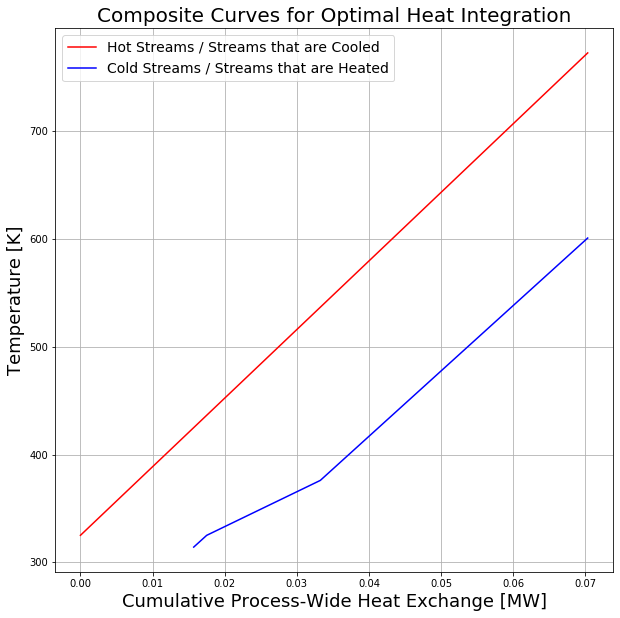

In [41]:
heat_integration(m.fs, [m.fs.H101,m.fs.F102], [m.fs.F101], 10, 1E-4)
CD =  Heat_ex_data(m.fs,[m.fs.H101,m.fs.F102], [m.fs.F101])
generate_curves(CD)

Heat integration
--------------------------

Let us declare the new objective function using heat integration variables (Qs heat content of heating utility and Qw heat content of cooling utility)

In [42]:
m.fs.objective = Objective(expr=m.fs.Qw+m.fs.Qs)
# m.fs.objective = Objective(expr=m.fs.Qw)

In [43]:
solver.options = {'tol': 1e-5,
                  'mu_init': 1e-8,
                  'bound_push': 1e-8, 'max_iter':1000}
results = solver.solve(m, tee=True)

Ipopt 3.11.1: tol=1e-05
mu_init=1e-08
bound_push=1e-08
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1045
Number of nonzeros in inequality constraint Jacobian.:        9
Number of nonzeros in Lagrangian Hessian.............:      901

Total number of variables............................:      346
                     variables with only lower bounds:        8
         

Example on printing heat exchanger results

In [44]:
 print_HX_results(m, [m.fs.H101,m.fs.F102,m.fs.F101])

Heat Exchanger Summary: 
Heat exchanger:  fs.H101
       Inlet T:  314.085 K
      Outlet T:  600.000 K
             Q:  47281.986 J/s
Heat exchanger:  fs.F102
       Inlet T:  325.000 K
      Outlet T:  375.000 K
             Q:  7352.483 J/s
Heat exchanger:  fs.F101
       Inlet T:  771.846 K
      Outlet T:  325.000 K
             Q:  -70343.093 J/s


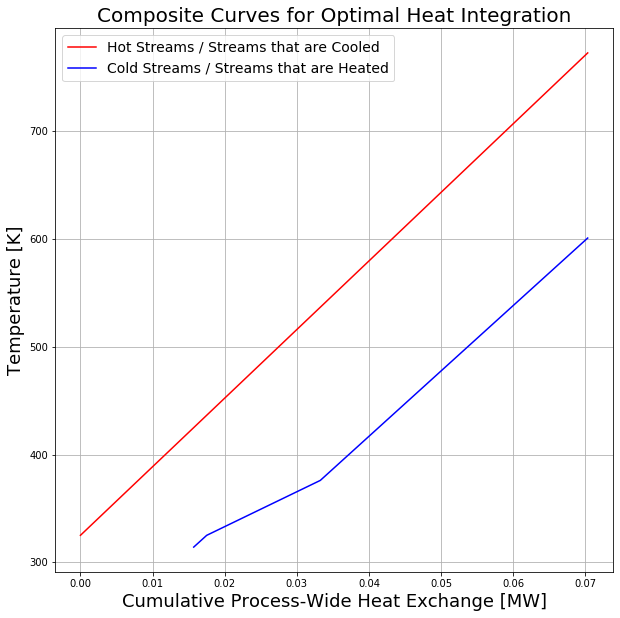

In [45]:
CD =  Heat_ex_data(m.fs,[m.fs.H101,m.fs.F102], [m.fs.F101])
generate_curves(CD)

In [46]:
print('operating cost = $', value(m.fs.operating_cost))

operating cost = $ 419122.33876779483


In [47]:
print(value(m.fs.Qw))
print(value(m.fs.Qs))

15708.623943475983
1e-08
